In [30]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)
%matplotlib inline

In [31]:
# Reading the file & loading in the data
raw = mne.io.read_raw_fif("group9_own_AH-raw.fif")
raw.info['bads'] = []
print(raw.info['ch_names'])
raw.load_data()

Opening raw data file group9_own_AH-raw.fif...
Isotrak not found
    Range : 1570000 ... 1900000 =   1570.000 ...  1900.000 secs
Ready.
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', '41']
Reading 0 ... 330000  =      0.000 ...   330.000 secs...


Measurement date,"April 08, 2024 08:55:32 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"32 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


In [32]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

# common average reference
raw.set_eeg_reference('average', projection=True)

# applying the reference
raw.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,"April 08, 2024 08:55:32 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


In [33]:
# Filtering data
raw.filter(.1, 40., fir_design="firwin")


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Measurement date,"April 08, 2024 08:55:32 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 1 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


In [34]:
# Removing bads
raw.info["bads"] = ["P3", "PO10", "PO9"]
raw.pick_types(meg= False, eeg=True, misc=True, exclude=[])

#raw_fit = raw.copy().filter(1, 40)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,"April 08, 2024 08:55:32 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"29 EEG, 1 misc"
Bad channels,"P3, PO10, PO9"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


In [35]:
# Function outputs an array and a list, naming both of these
events, event_boop = mne.events_from_annotations(raw)

event_boop

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 53', 'Stimulus/S 55', 'Stimulus/S 68', 'Stimulus/S 69']


{'Stimulus/S 11': 11,
 'Stimulus/S 12': 12,
 'Stimulus/S 13': 13,
 'Stimulus/S 21': 21,
 'Stimulus/S 22': 22,
 'Stimulus/S 23': 23,
 'Stimulus/S 31': 31,
 'Stimulus/S 32': 32,
 'Stimulus/S 53': 53,
 'Stimulus/S 55': 55,
 'Stimulus/S 68': 68,
 'Stimulus/S 69': 69}

In [36]:
# Shifting data to fit diode
events_diode = events.copy()

# List of triggers to be shifted by 16ms
triggers_16ms = [11, 12, 13]

# List of triggers to be shifted by 33.33ms
triggers_33ms = [21, 22, 23]

for event in events:
    trigger = event[2]
    if trigger in triggers_16ms:
        event[0] += 16
    elif trigger in triggers_33ms:
        event[0] += 33.33

events[:20, :]

array([[1579332,       0,      68],
       [1579863,       0,      11],
       [1580847,       0,      69],
       [1581330,       0,      23],
       [1589163,       0,      55],
       [1589164,       0,      32],
       [1589180,       0,      68],
       [1589780,       0,      11],
       [1590765,       0,      69],
       [1591297,       0,      22],
       [1591931,       0,      31],
       [1591947,       0,      68],
       [1592513,       0,      13],
       [1593498,       0,      69],
       [1593930,       0,      21],
       [1594605,       0,      31],
       [1594614,       0,      68],
       [1595213,       0,      12],
       [1596197,       0,      69],
       [1596714,       0,      21]])

Updated diode event IDs: {'Target_M': 21, 'Target_F': 22, 'Target_N': 23}
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_7436/143391472.py:60: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  adjusted_epochs_diode.plot_image(picks='41')


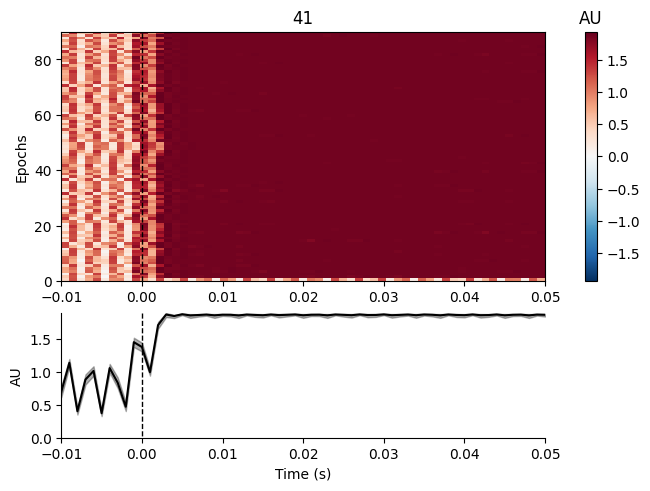

In [37]:
import numpy as np
import mne

# Step 4: Rename and filter relevant events for diode check
diode_event_id = {
#    'Prime_M': 11,  # prime masculine
 #   'Prime_F': 12,  # prime feminine
  #  'Prime_N': 13  # prime neutral
    'Target_M': 21, # target masculine
    'Target_F': 22, # target feminine
    'Target_N': 23  # target neutral
}

# Verify and update diode event IDs
updated_diode_event_id = {k: v for k, v in diode_event_id.items() if v in np.unique(events[:, 2])}
print("Updated diode event IDs:", updated_diode_event_id)

# Check if updated_diode_event_id is not empty
if not updated_diode_event_id:
    print("No matching events found for the specified diode event IDs.")
else:
    # Step 5: Create epochs for diode checking
    tmin_d, tmax_d = -0.01, 0.05  # Narrow window for inspecting delays
    baseline = None  # No baseline correction here to manually adjust later

    epochs_diode = mne.Epochs(
        raw,
        events=events,
        event_id=updated_diode_event_id,
        tmin=tmin_d,
        tmax=tmax_d,
        baseline=baseline,  # No baseline correction
        preload=True,  # Preload the data to allow direct manipulation
        verbose=False,
    )

    # Step 6: Adjust baseline to make minimum value zero
    diode_channel_index = epochs_diode.ch_names.index('41')
    data = epochs_diode.get_data(picks=diode_channel_index)
    min_value = data.min()
    adjusted_data = data - min_value

    # Create a new info object for the diode channel
    diode_info = mne.create_info(
        ch_names=['41'],
        sfreq=raw.info['sfreq'],
        ch_types=['misc']  # Assuming '41' is a miscellaneous channel
    )

    # Create a new epochs object with adjusted data
    adjusted_epochs_diode = mne.EpochsArray(
        adjusted_data,
        info=diode_info,
        events=epochs_diode.events,
        tmin=epochs_diode.tmin,
        event_id=epochs_diode.event_id,
    )

    # Plot adjusted diode epochs
    adjusted_epochs_diode.plot_image(picks='41')